# Alphalens Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())    

## Linear Regression

In [9]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL      -0.000176
                           AAPL     -0.002003
                           ABBV      0.001249
                           AGN       0.002675
                           AIG      -0.000867
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 258 entries, AAL to MAT
dtypes: float64(258)
memory usage: 2.0 MB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74038 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'TXN')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74038 non-null  float64
 1   5D               74038 non-null  float64
 2   10D              74038 non-null  float64
 3   21D              74038 non-null  float64
 4   factor           74038 non-null  float64
 5   factor_quantile  74038 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.043520,0.008755,-0.003163,0.003941,14982,20.235555
2,-0.014779,0.011103,-0.001028,0.003333,14863,20.074826
3,-0.012614,0.012602,0.000086,0.003335,14348,19.379238
4,-0.011262,0.014253,0.001150,0.003432,14863,20.074826
5,-0.008721,0.037225,0.003239,0.004181,14982,20.235555


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.026,0.033,0.037,0.018
beta,0.009,-0.049,-0.017,0.059
Mean Period Wise Return Top Quantile (bps),2.278,1.825,1.670,1.612
Mean Period Wise Return Bottom Quantile (bps),-1.410,-0.763,-1.014,-0.793
Mean Period Wise Spread (bps),3.688,2.606,2.698,2.388


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.018,0.024,0.028
IC Std.,0.184,0.176,0.176,0.167
Risk-Adjusted IC,0.108,0.102,0.134,0.169
t-stat(IC),2.959,2.797,3.678,4.620
p-value(IC),0.003,0.005,0.000,0.000
IC Skew,-0.054,-0.105,-0.127,-0.021
IC Kurtosis,-0.098,-0.136,-0.063,-0.291


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.284,0.506,0.610,0.719
Quantile 2 Mean Turnover,0.503,0.692,0.753,0.793
Quantile 3 Mean Turnover,0.551,0.729,0.776,0.807
Quantile 4 Mean Turnover,0.504,0.694,0.749,0.785
Quantile 5 Mean Turnover,0.288,0.513,0.629,0.740


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.836,0.575,0.418,0.249


<Figure size 432x288 with 0 Axes>

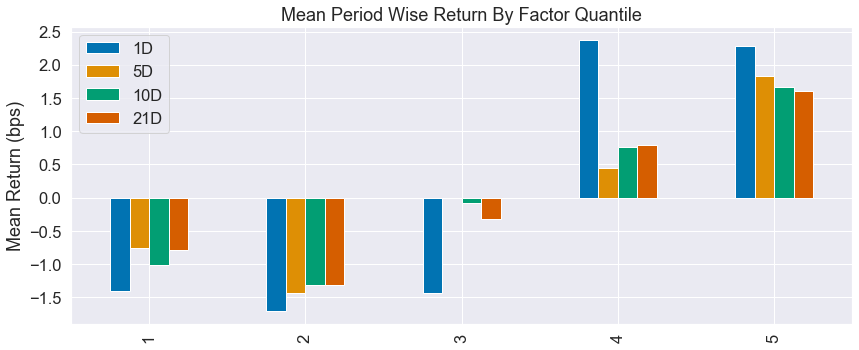

In [13]:
create_summary_tear_sheet(lr_factor_data);

## Ridge Regression

In [14]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [15]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000284
                           AAPL     -0.001743
                           ABBV      0.001264
                           AGN       0.002620
                           AIG      -0.000775
dtype: float64

In [16]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74038 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'TXN')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74038 non-null  float64
 1   5D               74038 non-null  float64
 2   10D              74038 non-null  float64
 3   21D              74038 non-null  float64
 4   factor           74038 non-null  float64
 5   factor_quantile  74038 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.039578,0.009219,-0.003494,0.003628,14982,20.235555
2,-0.012613,0.011656,-0.001429,0.003104,14863,20.074826
3,-0.010515,0.012887,-0.000345,0.003148,14348,19.379238
4,-0.009288,0.014515,0.000686,0.003276,14863,20.074826
5,-0.007255,0.036538,0.002706,0.004064,14982,20.235555


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.025,0.032,0.037,0.018
beta,0.010,-0.050,-0.018,0.062
Mean Period Wise Return Top Quantile (bps),2.325,1.786,1.739,1.610
Mean Period Wise Return Bottom Quantile (bps),-1.434,-0.824,-1.062,-0.852
Mean Period Wise Spread (bps),3.760,2.628,2.819,2.448


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.019,0.024,0.028
IC Std.,0.184,0.177,0.176,0.167
Risk-Adjusted IC,0.108,0.105,0.137,0.168
t-stat(IC),2.960,2.864,3.746,4.596
p-value(IC),0.003,0.004,0.000,0.000
IC Skew,-0.054,-0.109,-0.148,-0.042
IC Kurtosis,-0.105,-0.156,-0.037,-0.254


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.279,0.500,0.606,0.716
Quantile 2 Mean Turnover,0.495,0.690,0.752,0.793
Quantile 3 Mean Turnover,0.548,0.729,0.775,0.806
Quantile 4 Mean Turnover,0.500,0.691,0.748,0.785
Quantile 5 Mean Turnover,0.283,0.508,0.626,0.738


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.839,0.585,0.425,0.254


<Figure size 432x288 with 0 Axes>

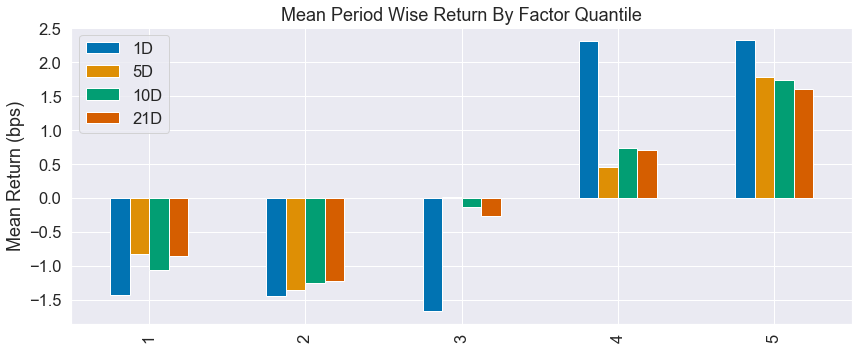

In [17]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso Regression

In [18]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [19]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.000108
                           AAPL     -0.001775
                           ABBV      0.001246
                           AGN       0.002613
                           AIG      -0.000849
dtype: float64

In [20]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74038 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'TXN')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74038 non-null  float64
 1   5D               74038 non-null  float64
 2   10D              74038 non-null  float64
 3   21D              74038 non-null  float64
 4   factor           74038 non-null  float64
 5   factor_quantile  74038 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.040391,0.009398,-0.003492,0.003725,14982,20.235555
2,-0.013994,0.011748,-0.001424,0.003216,14863,20.074826
3,-0.011899,0.013037,-0.000336,0.003278,14348,19.379238
4,-0.010599,0.014708,0.000694,0.003409,14863,20.074826
5,-0.007921,0.038398,0.002727,0.004220,14982,20.235555


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.026,0.032,0.037,0.018
beta,0.009,-0.049,-0.015,0.064
Mean Period Wise Return Top Quantile (bps),2.374,1.917,1.769,1.690
Mean Period Wise Return Bottom Quantile (bps),-1.263,-0.874,-1.187,-0.814
Mean Period Wise Spread (bps),3.637,2.812,2.973,2.490


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.019,0.024,0.029
IC Std.,0.184,0.177,0.177,0.168
Risk-Adjusted IC,0.107,0.104,0.138,0.171
t-stat(IC),2.935,2.861,3.771,4.692
p-value(IC),0.003,0.004,0.000,0.000
IC Skew,-0.057,-0.117,-0.149,-0.044
IC Kurtosis,-0.092,-0.140,-0.046,-0.250


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.281,0.503,0.607,0.717
Quantile 2 Mean Turnover,0.498,0.691,0.750,0.792
Quantile 3 Mean Turnover,0.547,0.729,0.775,0.808
Quantile 4 Mean Turnover,0.500,0.690,0.745,0.784
Quantile 5 Mean Turnover,0.284,0.509,0.625,0.741


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.838,0.58,0.422,0.248


<Figure size 432x288 with 0 Axes>

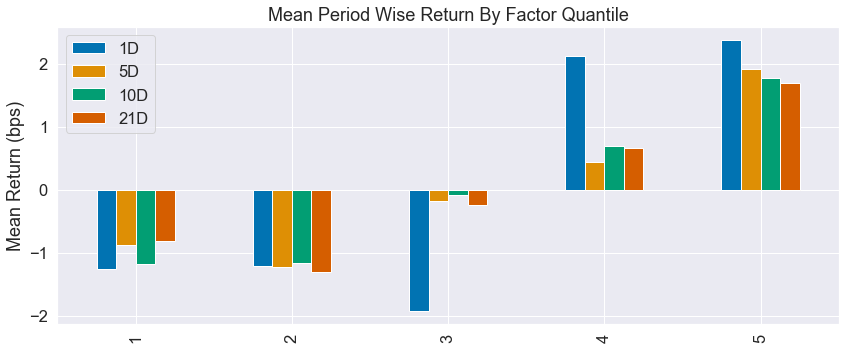

In [21]:
create_summary_tear_sheet(lasso_factor_data);